In [1]:
import pandas as pd
import numpy as np
import janitor
from pathlib import Path
import missingno
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (11, 9.4)
sns.set_style("whitegrid")
sns.set_context(context='notebook')

custom_palette = {0: "#1f77b4", 1: "#ff7f0e"}


In [3]:
data_path = Path("data")
train_path = Path("data", "train.csv")
test_path = Path("data", "test_public.csv")
test_private_path = Path("data", "test_private.csv")

train_parquet_path = Path("data", "train.parquet")
test_parquet_path = Path("data", "test_public.parquet")

In [4]:
# train_df = pd.read_csv(train_path)  
test_df = pd.read_csv(test_path)
test_private_df = pd.read_csv(test_private_path)

In [5]:
train_df = pd.read_parquet(train_parquet_path)

In [6]:
target_col = "CHD_OR_MI"
numerical_cols = ["AGE", "BMI"]
categorical_cols = list(set(train_df.columns) - set(numerical_cols) - set(["ID", "CHD_OR_MI"]))
train_df[categorical_cols] = train_df[categorical_cols].astype("category")

In [7]:
train_df.describe()

,CHD_OR_MI,AGE,BMI
count,347246.000000,347246.000000,310286.000000
mean,0.918623,54.607679,2855.145811
std,0.273414,17.557646,652.370720
min,0.000000,18.000000,1200.000000
25%,1.000000,40.000000,2414.000000
50%,1.000000,57.000000,2744.000000
75%,1.000000,69.000000,3175.000000
max,1.000000,80.000000,9933.000000


In [8]:
train_df.describe(include="category")

,SEX,HEALTH,PHYSICAL_HEALTH,MENTAL_HEALTH,PHYSICAL_ACTIVITIES,BLOOD_PRESSURE,HIGH_CHOLESTEROL,SKIN_CANCER,CANCER,BRONCHITIS,...,DIFFICULTY_WALKING,SMOKE,TABACCO_PRODUCTS,E_CIGARETTES,HEAVY_DRINKERS,HIV,FRUITS,VEGETABLES,FRIED_POTATOES,ETHNICITY
count,347246,346408.0,339940.0,341212.0,346593.0,345939.0,297055.0,346379.0,346454.0,345933.0,...,331642.0,327983.0,329213.0,328362.0,319663.0,306452.0,306992.0,299859.0,311944.0,347246
unique,2,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,3.0,4.0,2.0,2.0,2.0,2.0,3.0,6
top,2,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,3.0,3.0,1.0,2.0,1.0,1.0,1.0,1
freq,185970,289523.0,228286.0,214722.0,262398.0,210318.0,178719.0,314042.0,312945.0,319252.0,...,278844.0,195399.0,318762.0,246536.0,300696.0,203876.0,189180.0,244121.0,143488.0,263254


# EDA with RAW DATA 

## Missing values

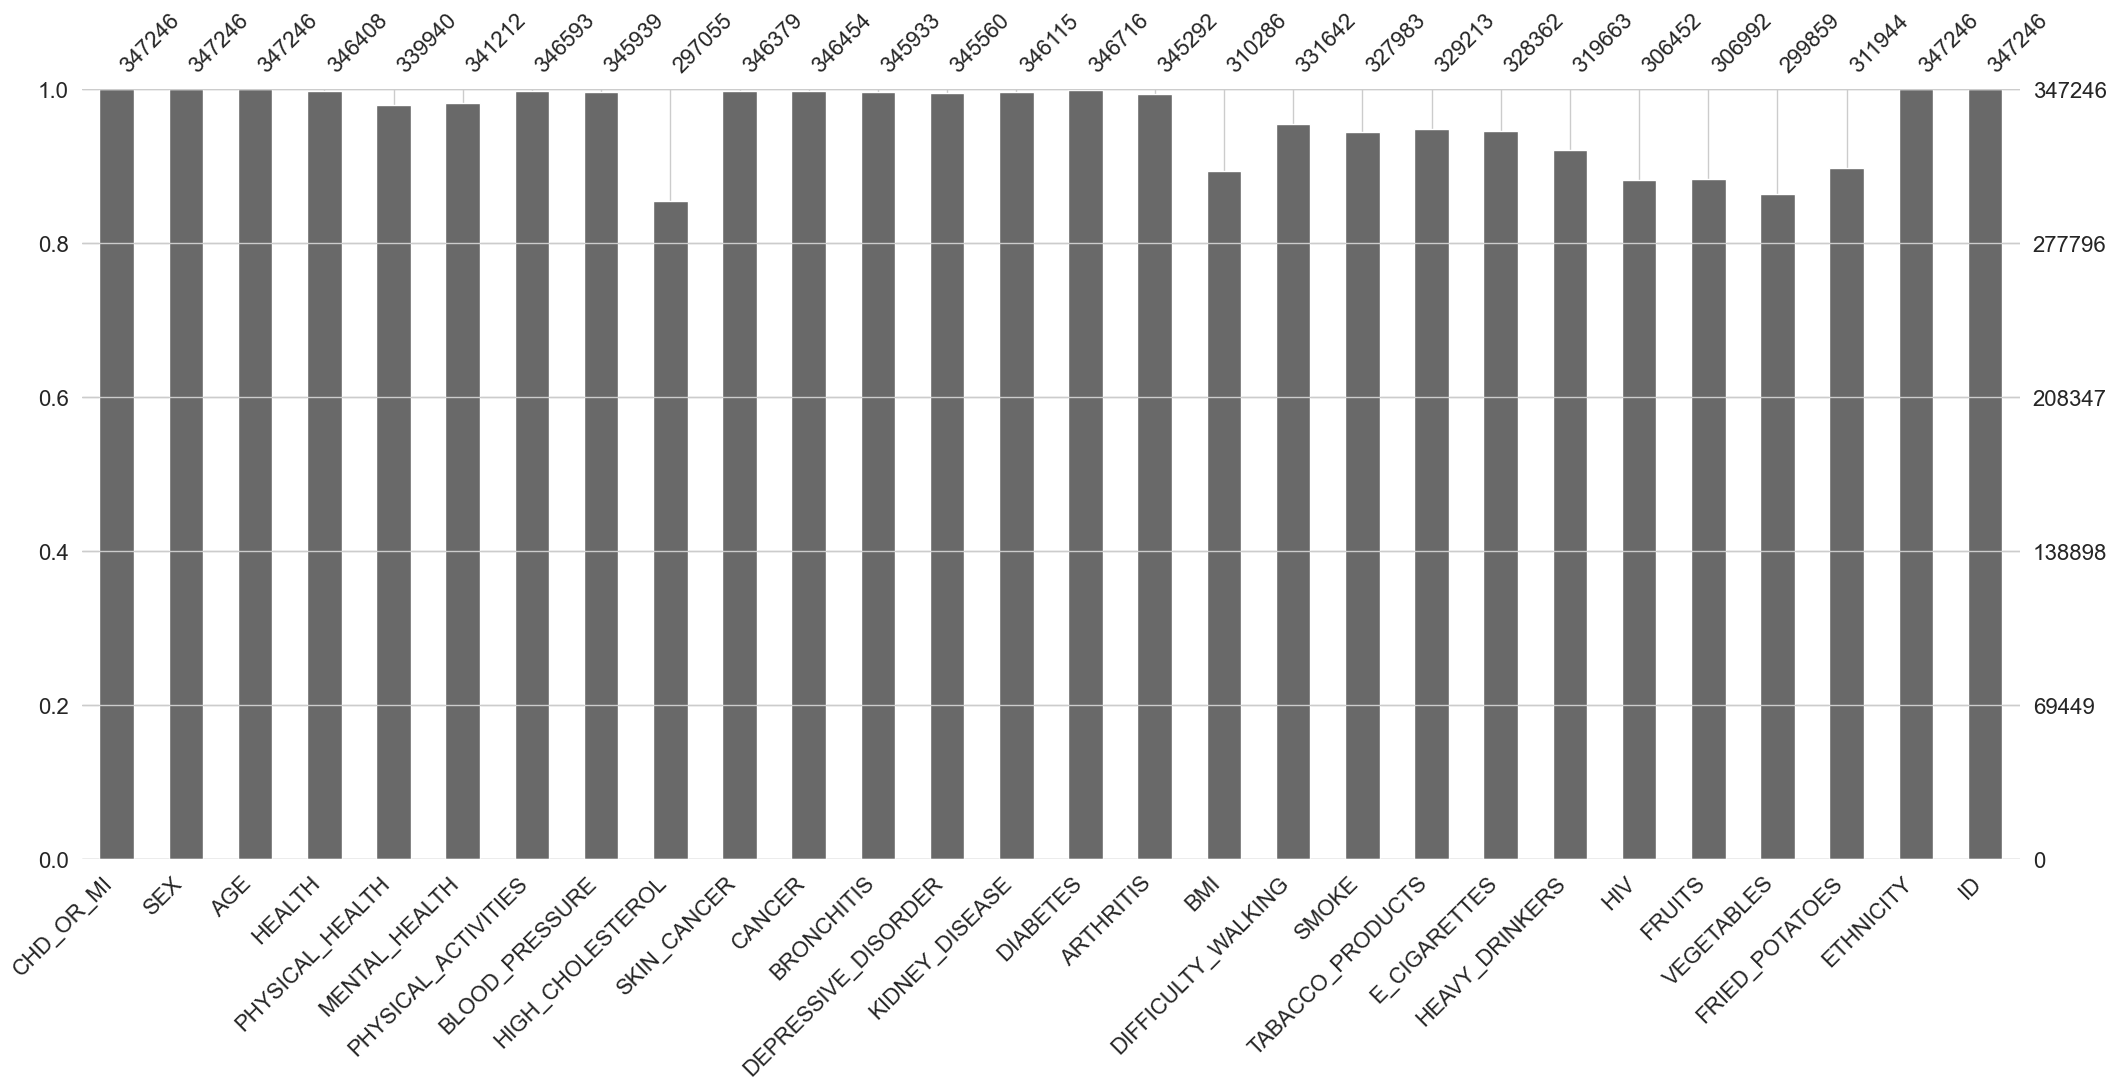

In [9]:
(
  train_df
  .pipe(missingno.bar)
)
excessive_missing_threshold = 0.4 * len(train_df)

<Axes: >

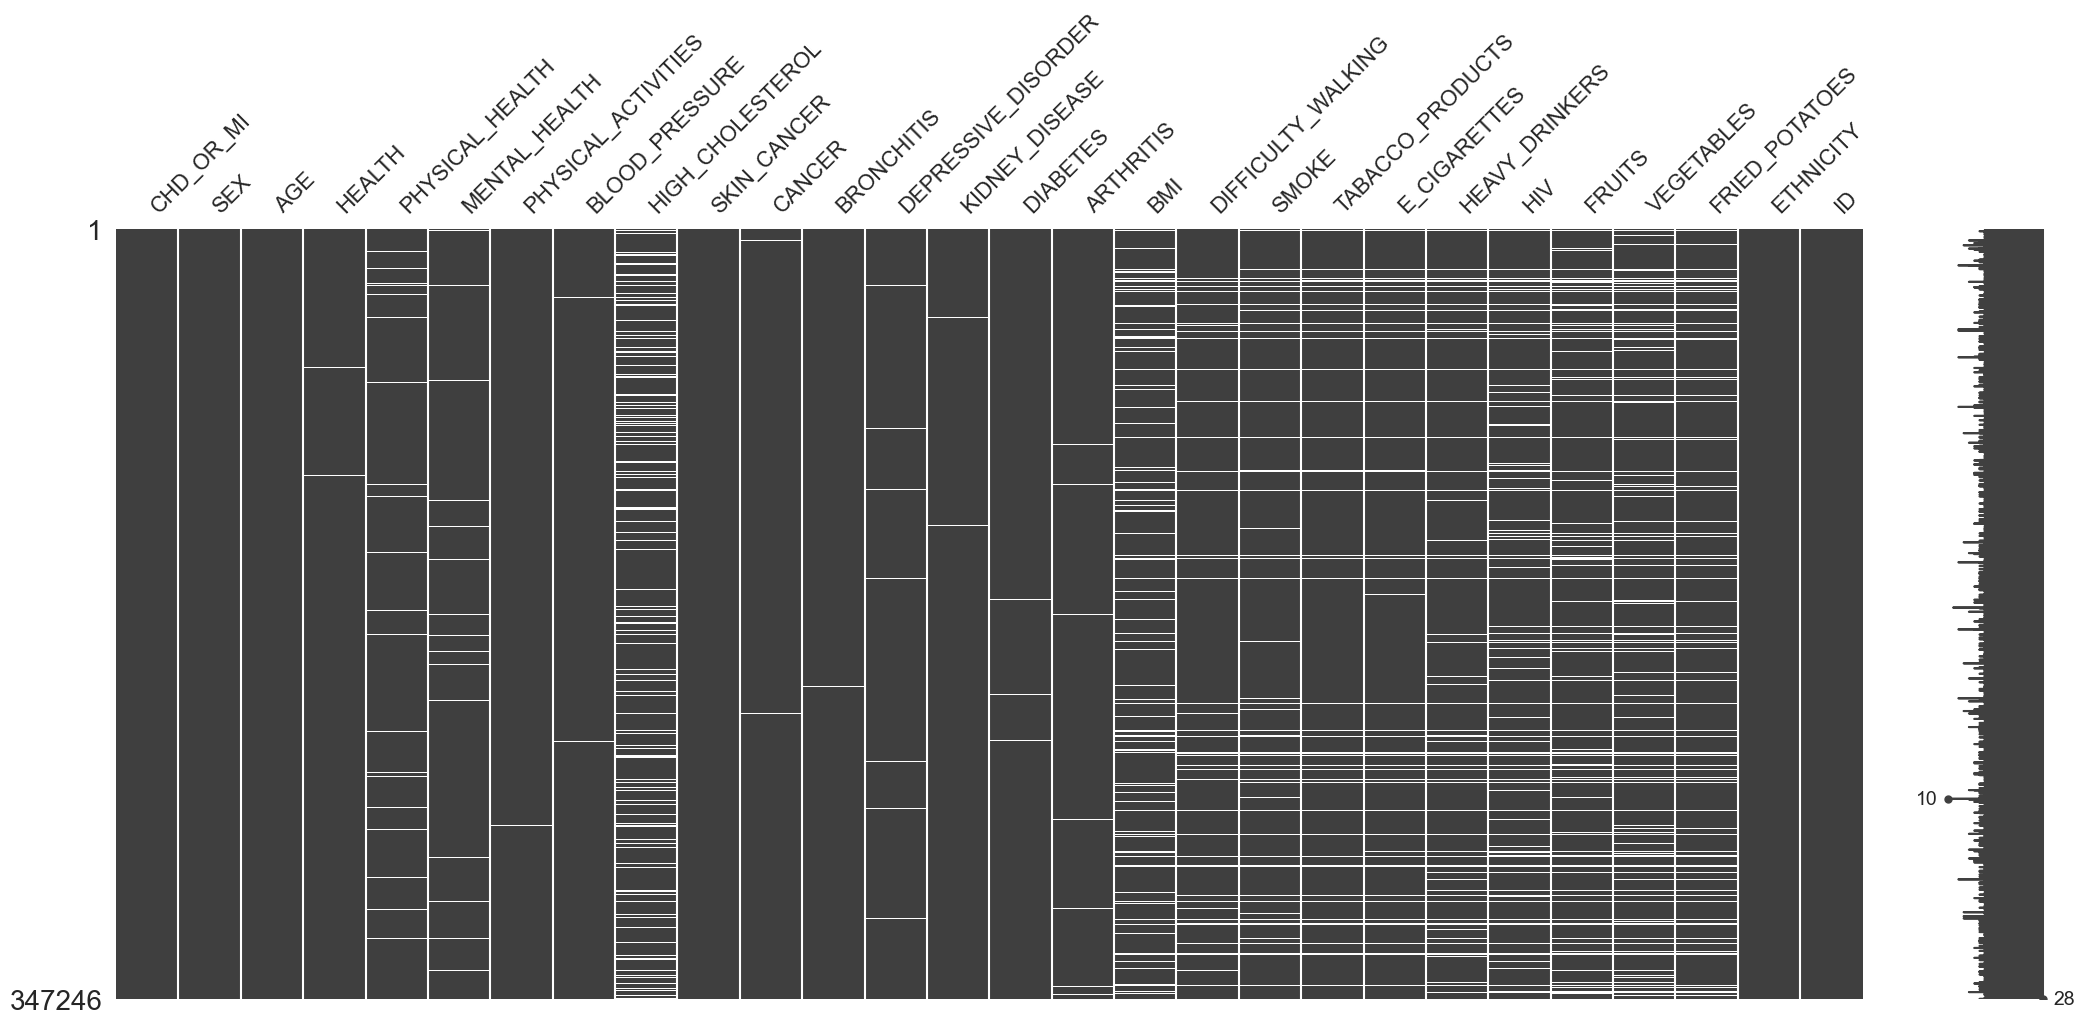

In [10]:
(
  train_df
  .pipe(missingno.matrix)
)

In [11]:
high_missings_columns = ['HIGH_CHOLESTEROL', 'VEGETABLES', 'HIV', 'FRUITS', 'BMI',
    'FRIED_POTATOES', 'HEAVY_DRINKERS', 'SMOKE', 'E_CIGARETTES',
    'TABACCO_PRODUCTS', 'DIFFICULTY_WALKING']

Clase 0: 28258 (8.14%)
Clase 1: 318988 (91.86%)
Ratio: 1 a 11.29


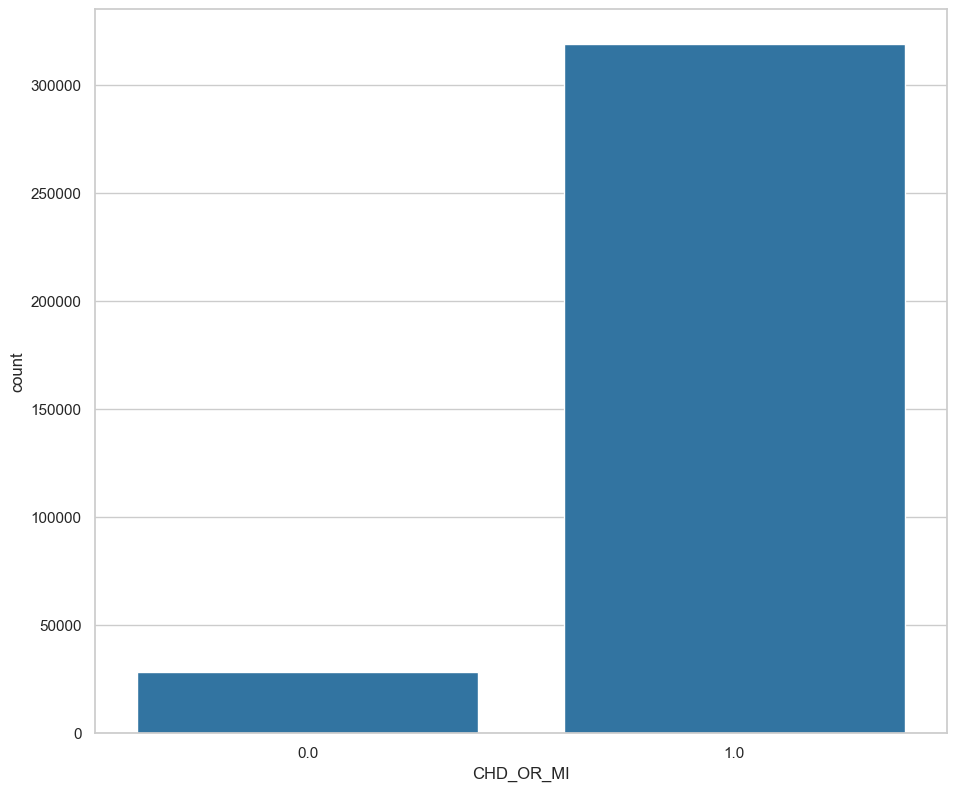

In [12]:
class_distribution = train_df["CHD_OR_MI"].value_counts(normalize=True) * 100
counts = train_df["CHD_OR_MI"].value_counts()
print(f"Clase 0: {counts[0]} ({counts[0] / len(train_df) * 100:.2f}%)")
print(f"Clase 1: {counts[1]} ({counts[1] / len(train_df) * 100:.2f}%)")
ratio = counts[1] / counts[0]
print(f"Ratio: 1 a {ratio:.2f}")
(
  train_df
  .select("CHD_OR_MI")
  .pipe(lambda df: sns.countplot(data=df, x="CHD_OR_MI"))
);


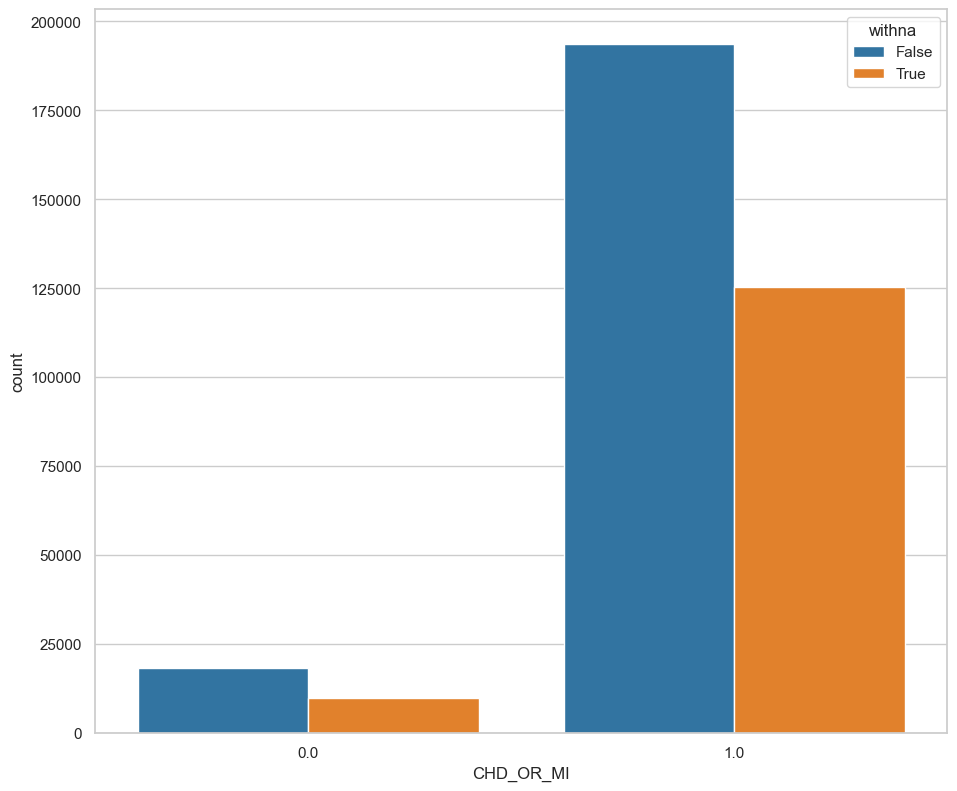

In [13]:
(
  train_df
  .assign(
    withna = lambda df: df.isna().sum(axis=1).astype(bool)
  )
  .pipe(lambda df: sns.countplot(data=df, x="CHD_OR_MI" ,hue="withna"))
);

In [92]:
# Imputación para valores numéricos
num_imputer = sklearn.impute.SimpleImputer(strategy="median")
cat_imputer = sklearn.impute.SimpleImputer(strategy="most_frequent")

def impute_data(df, fit= True,num_imputer=num_imputer, cat_imputer=cat_imputer):
    if fit:
        # df[df[target_col] == 0] = knn_imputer.fit_transform(df[df[target_col] == 0])
        df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])
        df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])
    else:
        df[numerical_cols] = num_imputer.transform(df[numerical_cols])
        df[categorical_cols] = cat_imputer.transform(df[categorical_cols])
    return df

train_df = impute_data(train_df)
# test_df = impute_data(test_df, fit=False)
# test_private_df = impute_data(test_private_df, fit=False)

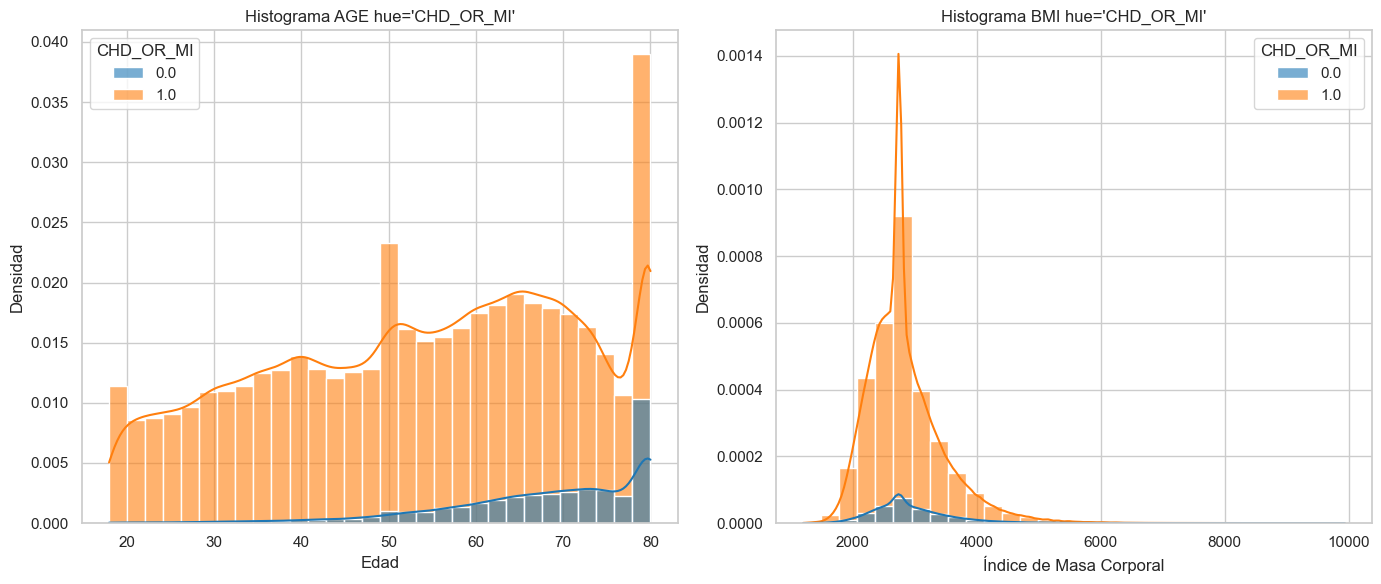

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Una fila, dos columnas

# Histograma para AGE
sns.histplot(
    data=train_df, 
    x="AGE", 
    hue="CHD_OR_MI", 
    bins=30, 
    stat="density", 
    kde=True, 
    alpha=0.6, 
    palette=custom_palette, 
    ax=axes[0]
)
axes[0].set_title("Histograma AGE hue='CHD_OR_MI'")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Densidad")

# Histograma para BMI
sns.histplot(
    data=train_df, 
    x="BMI", 
    hue="CHD_OR_MI", 
    bins=30, 
    stat="density", 
    kde=True, 
    alpha=0.6, 
    palette=custom_palette, 
    ax=axes[1]
)
axes[1].set_title("Histograma BMI hue='CHD_OR_MI'")
axes[1].set_xlabel("Índice de Masa Corporal")
axes[1].set_ylabel("Densidad")

plt.tight_layout()
plt.show()

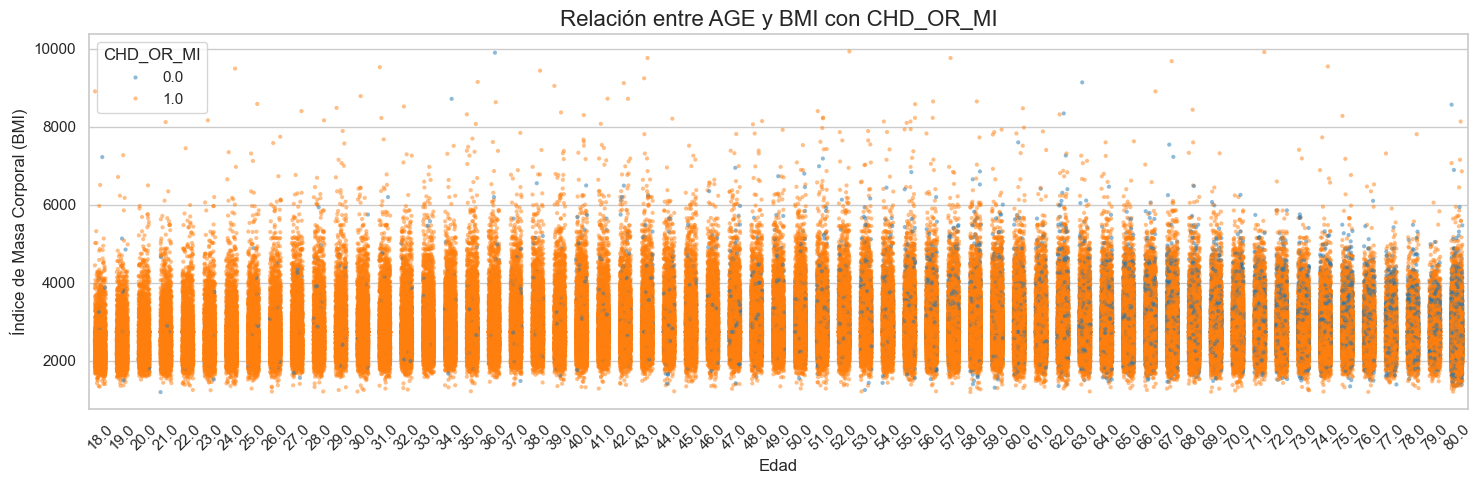

In [94]:
plt.figure(figsize=(15, 5));

sns.stripplot(
  data=train_df, 
  x="AGE", 
  y="BMI", 
  hue="CHD_OR_MI", 
  jitter=0.25, 
  alpha=0.5, 
  size=3, 
  palette=custom_palette
);

plt.title("Relación entre AGE y BMI con CHD_OR_MI", fontsize=16)
plt.xlabel("Edad", fontsize=12)
plt.ylabel("Índice de Masa Corporal (BMI)", fontsize=12)
plt.xticks(rotation=45)  # Rotar etiquetas del eje X
plt.tight_layout();
plt.show();

In [17]:
# # Fill missing values for categorical and numerical columns
# train_df[categorical_cols] = train_df[categorical_cols].fillna(train_df[categorical_cols].mode().iloc[0])
# train_df[numerical_cols] = train_df[numerical_cols].apply(
#     lambda col: col.fillna(col.median()) if col.isnull().sum() > 0 else col
# )

# # Remove columns with excessive missing values if any remain
# remaining_missing = train_df.isnull().sum()
# columns_to_drop = remaining_missing[remaining_missing > excessive_missing_threshold].index
# data_cleaned = train_df.drop(columns=columns_to_drop, axis=1)
  

In [18]:
# data_cleaned.isnull().sum().sum()


In [19]:
key_predictors = ['AGE', 'BMI', 'HEALTH', 'BLOOD_PRESSURE', 'HIGH_CHOLESTEROL']

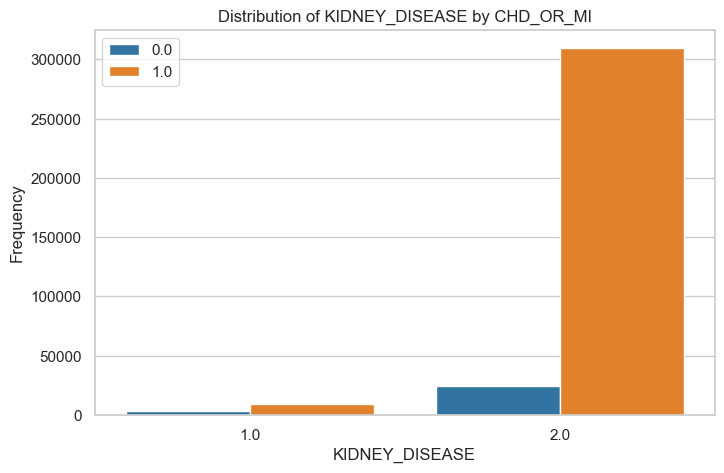

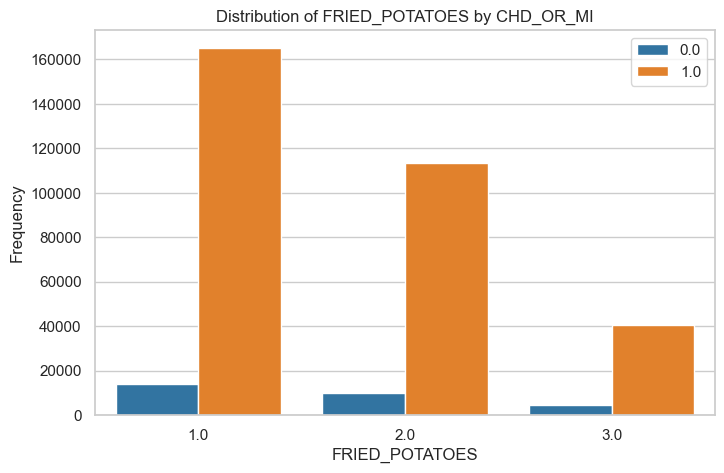

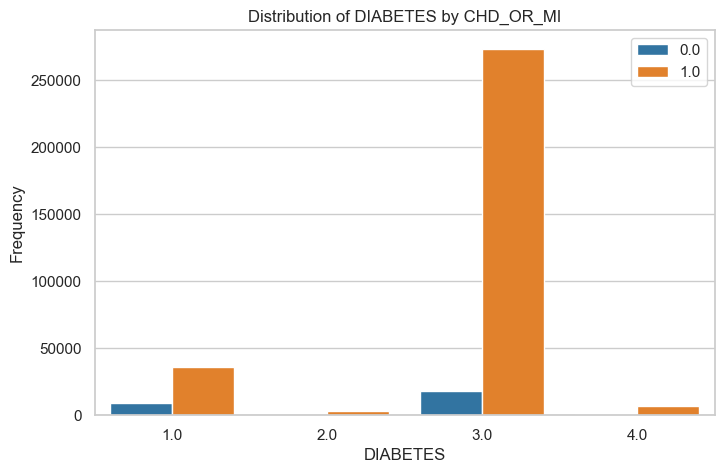

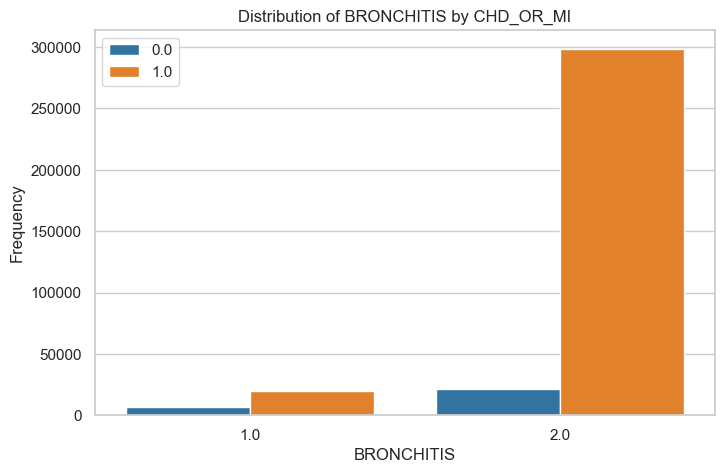

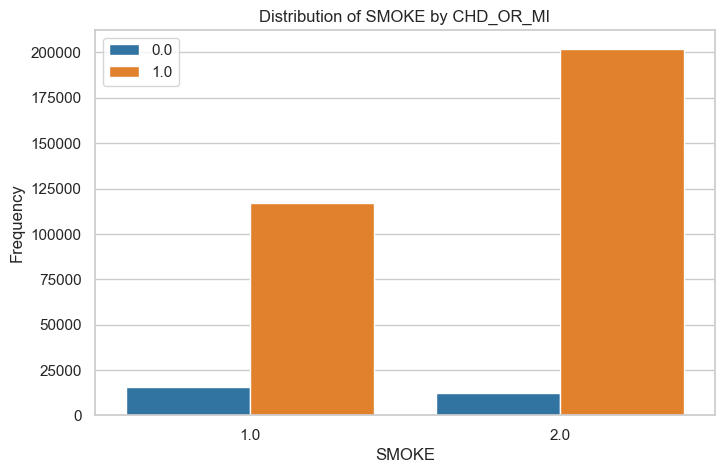

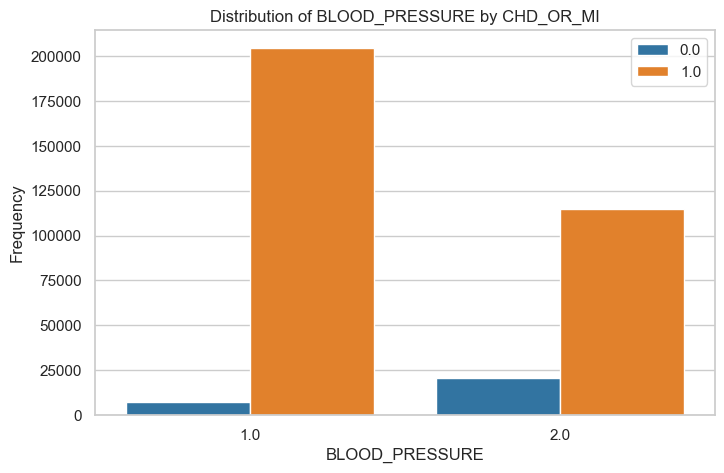

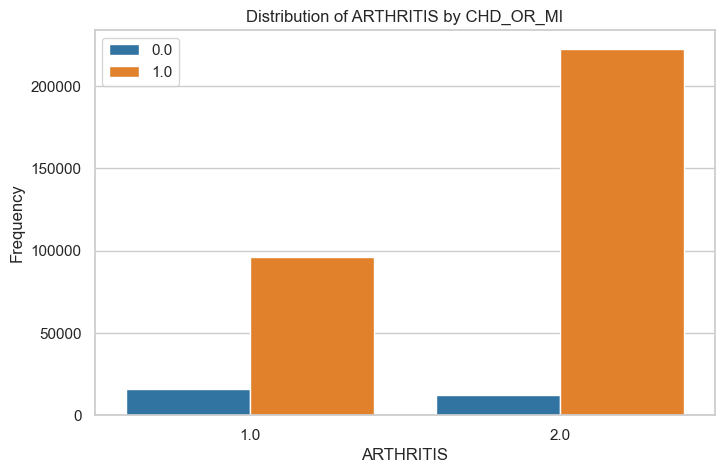

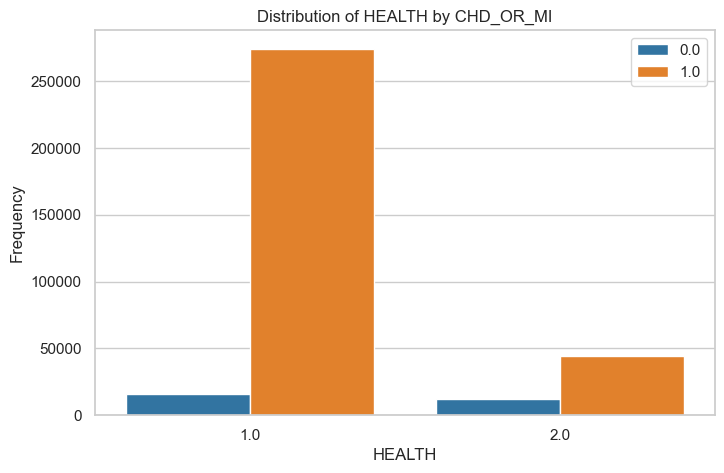

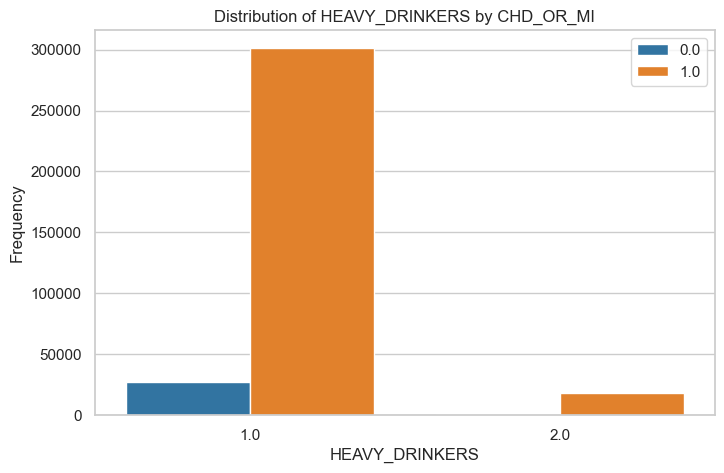

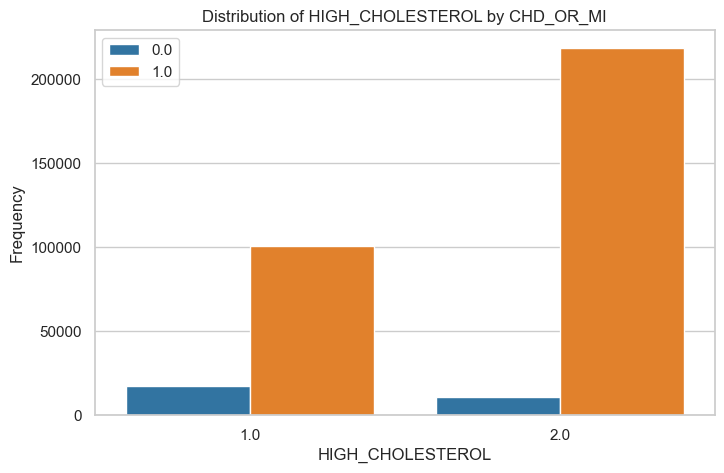

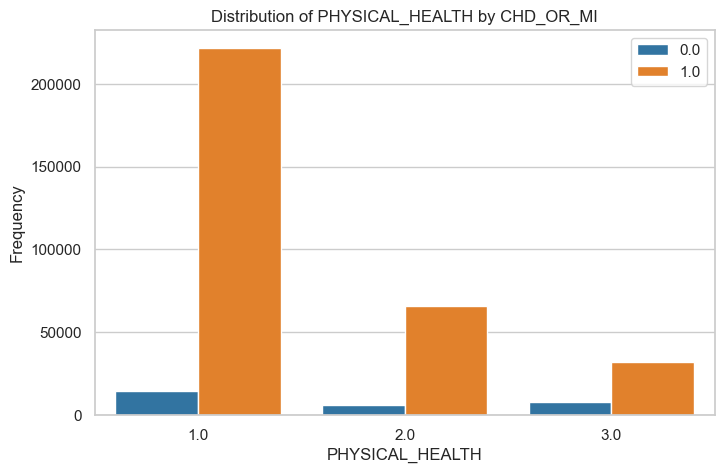

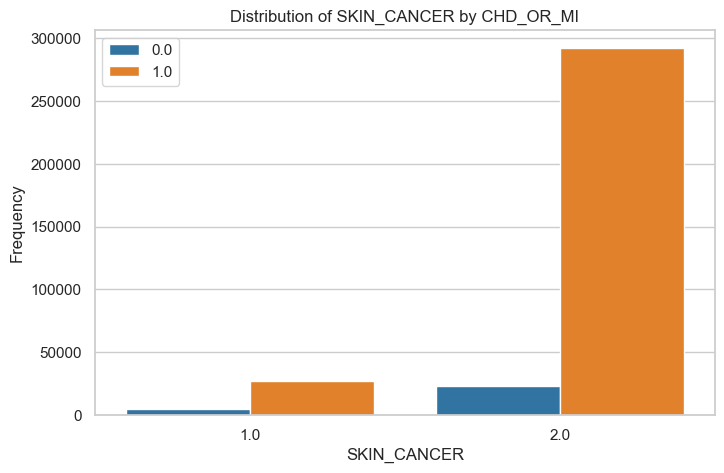

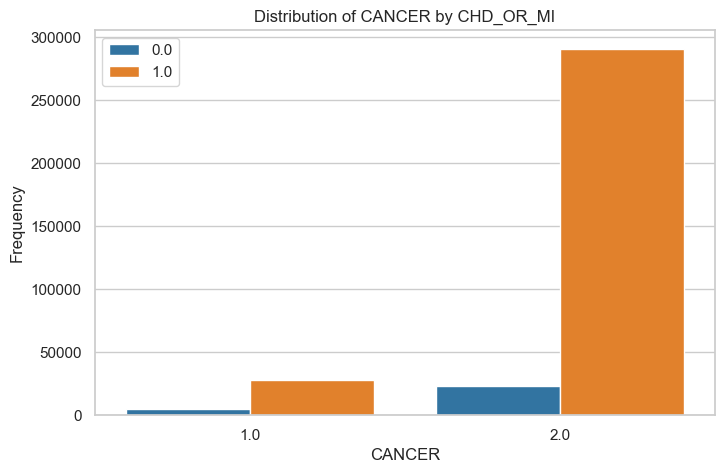

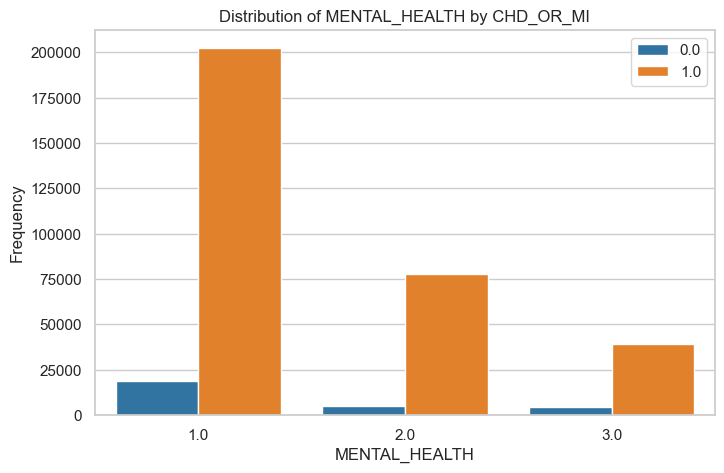

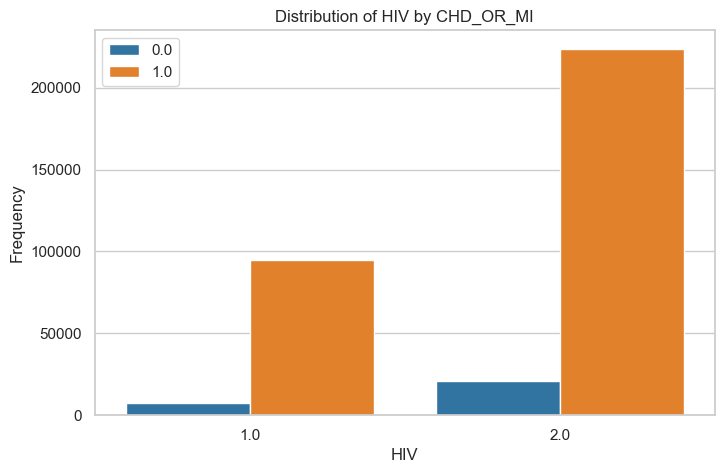

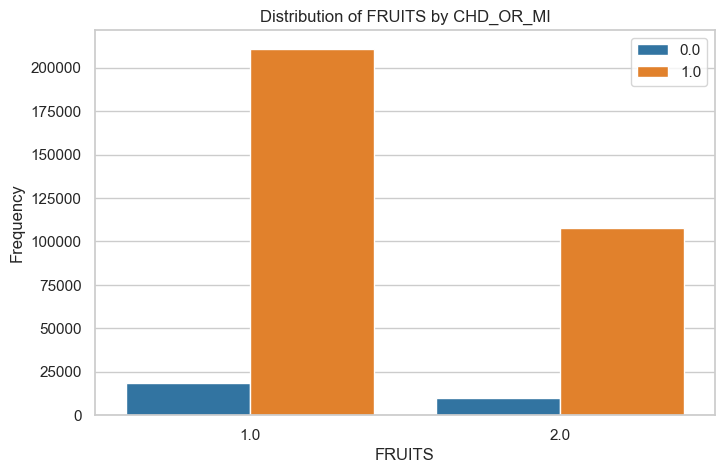

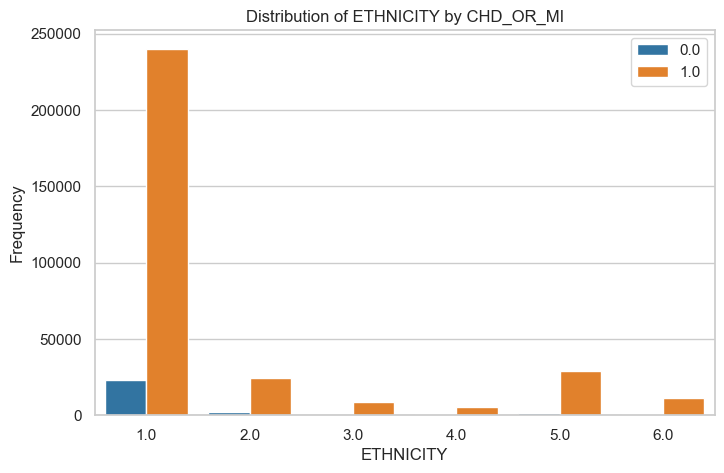

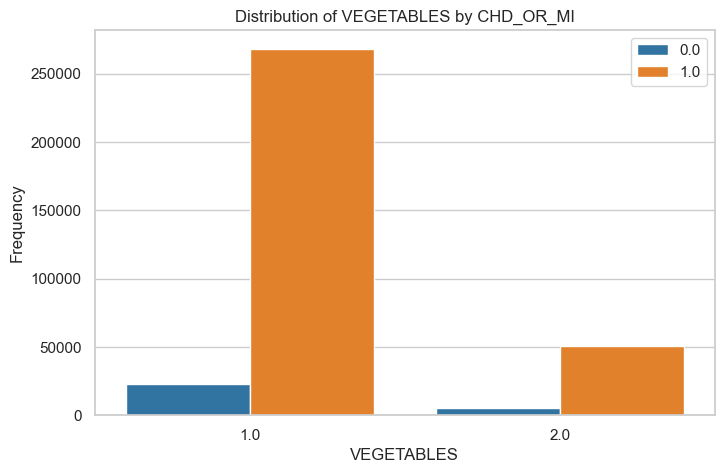

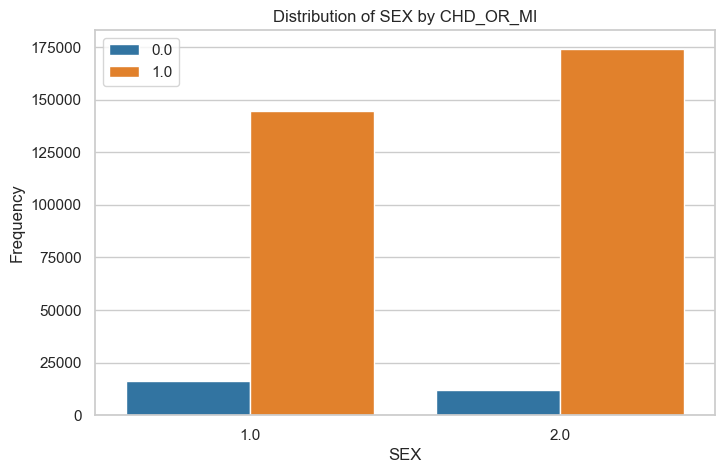

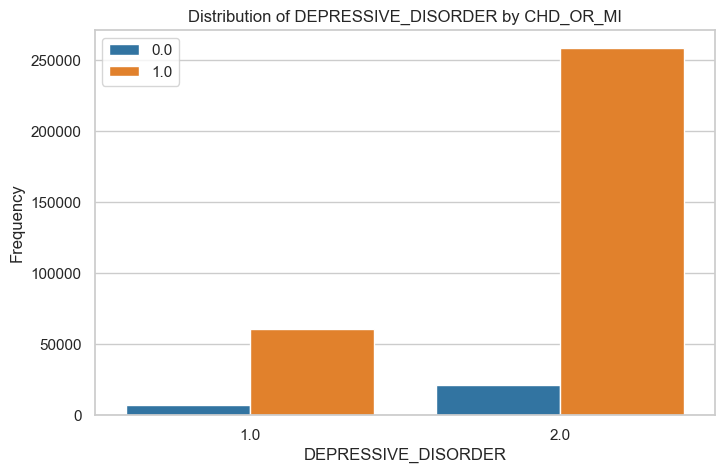

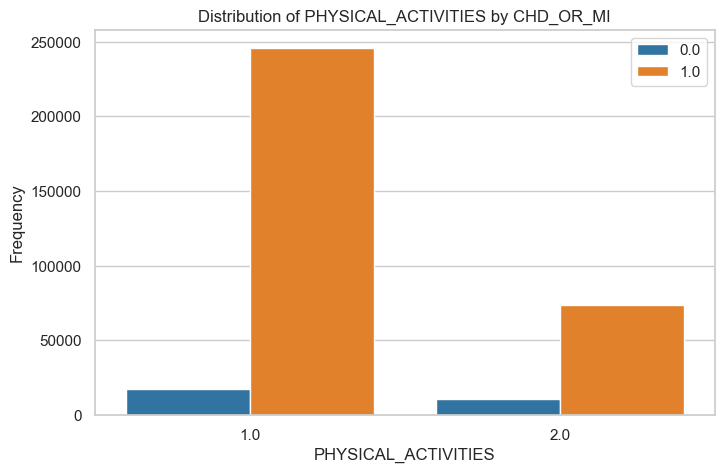

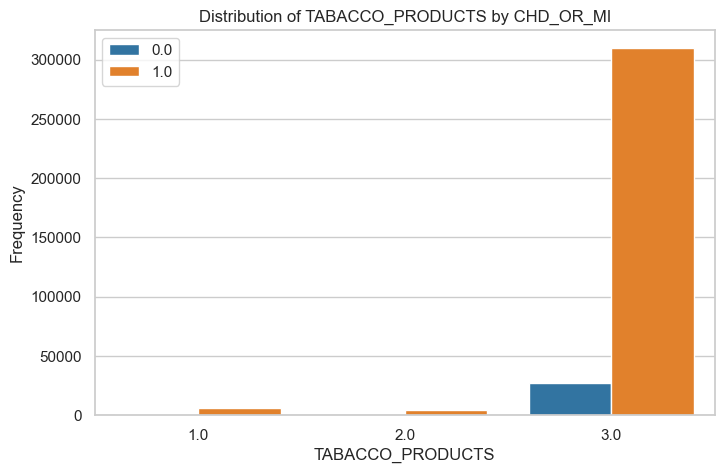

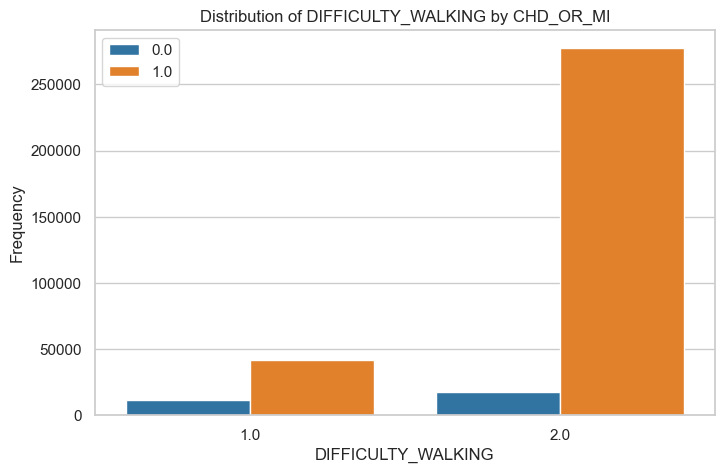

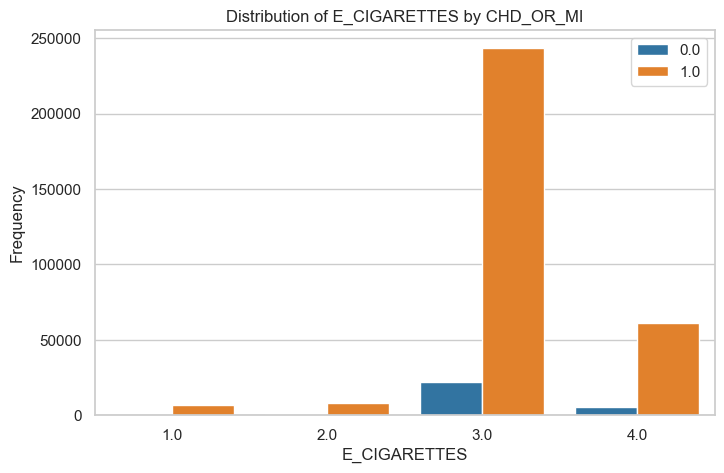

In [95]:
for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train_df, x=col, hue='CHD_OR_MI', palette=custom_palette)
    plt.title(f'Distribution of {col} by CHD_OR_MI')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [96]:
X_train = train_df.drop(columns=['CHD_OR_MI', 'ID'])
y_train = train_df['CHD_OR_MI']

X_test = test_df.drop(columns=['CHD_OR_MI', 'ID'])
y_test = test_df['CHD_OR_MI']

X_test_private = test_private_df.drop(columns=['ID'])

In [24]:
from imblearn.combine import SMOTEENN
# Balanceo con SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)

In [25]:
balanced_class_distribution = pd.Series(y_train_balanced).value_counts()

balanced_class_distribution

CHD_OR_MI
0.0    313886
1.0    217605
Name: count, dtype: int64

In [26]:
balanced_df = pd.concat([X_train_balanced, y_train_balanced], axis=1)

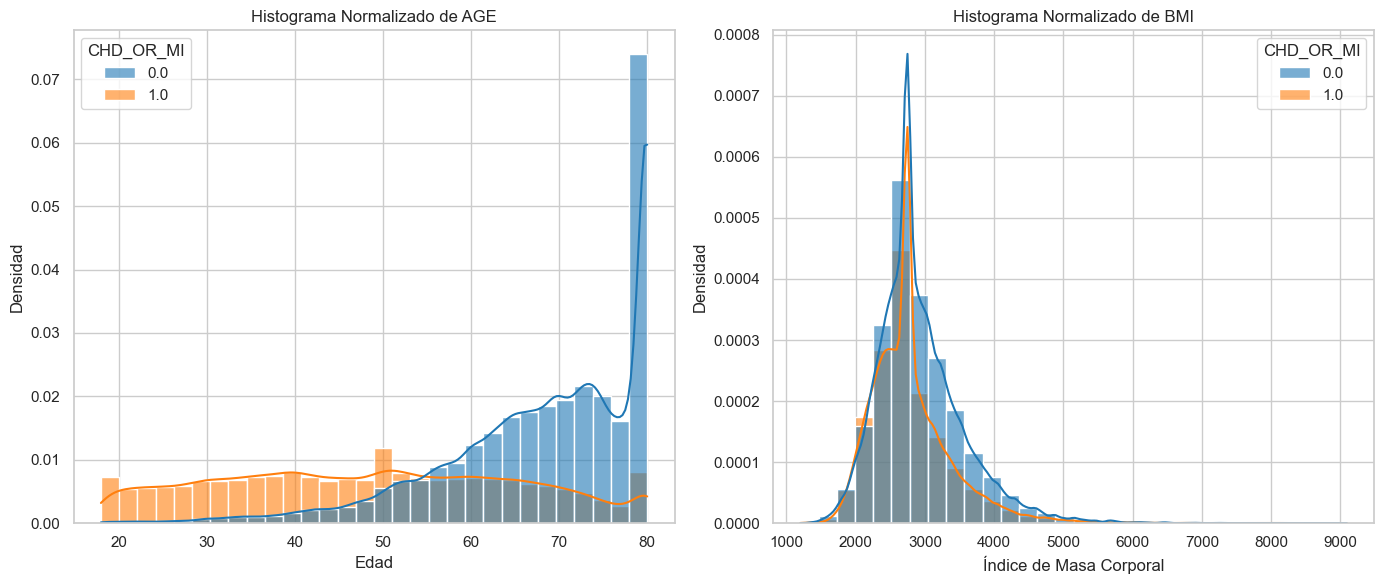

In [27]:
# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Una fila, dos columnas
(
  balanced_df
  .pipe( lambda df:
    sns.histplot(
      data=df,
      x="AGE", 
      hue="CHD_OR_MI", 
      bins=30,
      stat="density", 
      kde=True, 
      alpha=0.6, 
      palette=custom_palette, 
      ax=axes[0]
    )   
  )
)
axes[0].set_title("Histograma Normalizado de AGE")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Densidad")

(
  balanced_df
  .pipe( lambda df:
    sns.histplot(
      data=df,
      x="BMI", 
      hue="CHD_OR_MI", 
      bins=30,
      stat="density", 
      kde=True, 
      alpha=0.6, 
      palette=custom_palette, 
      ax=axes[1]
    )   
  )
)
axes[1].set_title("Histograma Normalizado de BMI")
axes[1].set_xlabel("Índice de Masa Corporal")
axes[1].set_ylabel("Densidad")

# Ajustar diseño
plt.tight_layout()
plt.show()

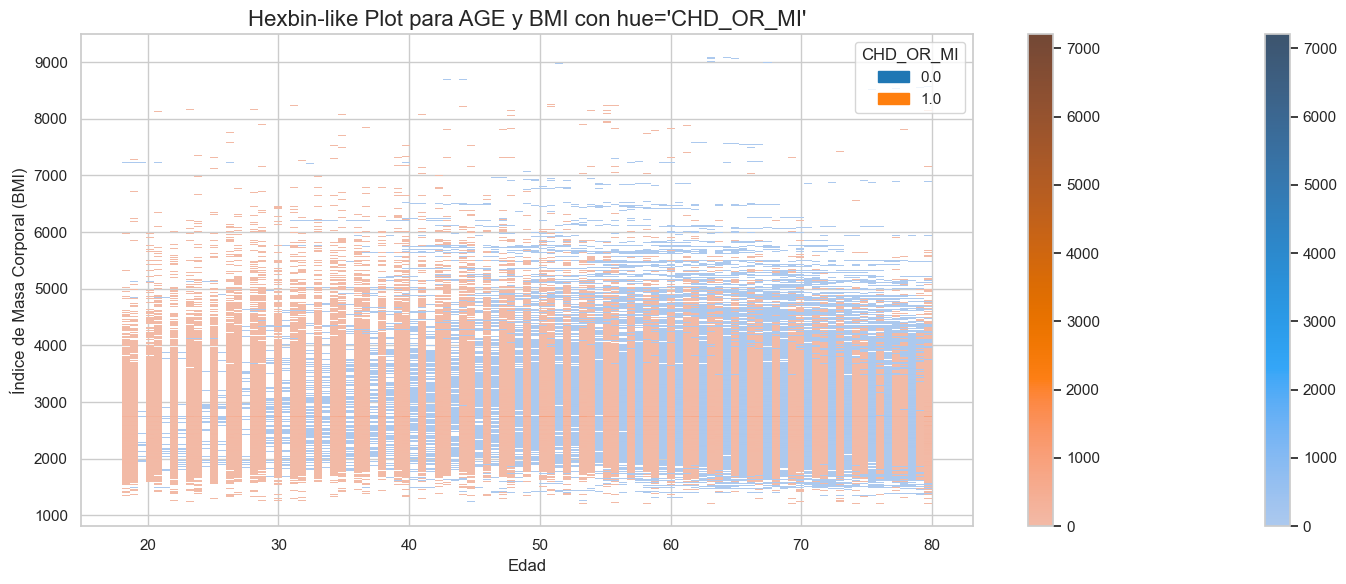

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el Hexbin-like plot con hue
plt.figure(figsize=(15, 6))
sns.histplot(
    data=balanced_df,
    x="AGE",
    y="BMI",
    hue="CHD_OR_MI",
    # bins=100,  # Ajusta el número de celdas
    # pmax=0.8,  # Recorte de valores máximos
    palette=custom_palette,  # Paleta de colores para hue
    cbar=True  # Añade una barra de colores
)
plt.title("Hexbin-like Plot para AGE y BMI con hue='CHD_OR_MI'", fontsize=16)
plt.xlabel("Edad", fontsize=12)
plt.ylabel("Índice de Masa Corporal (BMI)", fontsize=12)
plt.tight_layout()
plt.show()

In [75]:

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

# Crear modelo con los mejores hiperparámetros
best_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    verbose=0,
    # class_weights={0:1, 1:1},  # Mejores pesos
    depth=6,               # Mejor profundidad
    iterations=100,        # Mejor número de iteraciones
    learning_rate=0.01      # Mejor tasa de aprendizaje
)

# Entrenar el modelo con el conjunto de entrenamiento
best_model.fit(X_train_balanced, y_train_balanced)



In [90]:
# Predicciones de probabilidad
y_pred_proba = best_model.predict_proba(X_test)#[:, 0]
# y_pred = best_model.predict(X_test)#[:, 0]

# # Ajustar el umbral basado en el F1-Score
# thresholds = np.linspace(0.1, 0.9, 100)
# f1_scores = []

# for threshold in thresholds:
#     y_pred_temp = (y_pred_proba >= threshold).astype(int)
#     f1_scores.append(f1_score(y_test, y_pred_temp))

# best_threshold = thresholds[np.argmax(f1_scores)]
# print(f"Mejor umbral para F1-Score: {best_threshold:.2f}")

# # Predicciones finales usando el mejor umbral
# y_pred = (y_pred_proba >= best_threshold).astype(int)

# Evaluación del modelo
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

         0.0       0.24      0.67      0.35      3532
         1.0       0.96      0.81      0.88     39874

    accuracy                           0.80     43406
   macro avg       0.60      0.74      0.62     43406
weighted avg       0.91      0.80      0.84     43406


Confusion Matrix:
 [[ 2357  1175]
 [ 7509 32365]]


In [91]:
y_pred_proba

array([[0.45063112, 0.54936888],
       [0.14290201, 0.85709799],
       [0.47733563, 0.52266437],
       ...,
       [0.63457546, 0.36542454],
       [0.0923509 , 0.9076491 ],
       [0.21103208, 0.78896792]])

In [78]:
model = best_model

In [79]:
y_test_private_pred = model.predict_proba(X_test_private)[:, 1]
y_test_private_pred = (y_test_private_pred >= best_threshold).astype(int)
submission_private = pd.DataFrame({
    "ID": test_private_df["ID"],
    "CHD_OR_MI": y_test_private_pred
})

submission_public = pd.DataFrame({
  "ID": test_df["ID"],
  "CHD_OR_MI": y_pred
})
submission_df = pd.concat([submission_private, submission_public] ,ignore_index=True)
# submission_df["CHD_OR_MI"] = submission_df["CHD_OR_MI"].astype
submission_df
submission_df.to_csv("submission.csv", index=False)